# **Exercice 1 : Autoencodeurs parcimonieux (SAE)**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist # fonctions pour charger et tracer les données
import numpy as np

import matplotlib.pyplot as plt

## Chargement et transformation des données

In [3]:
p = 28

mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)


# Pour mettre sur GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device :', device)

device : cuda


## Visualisation des données

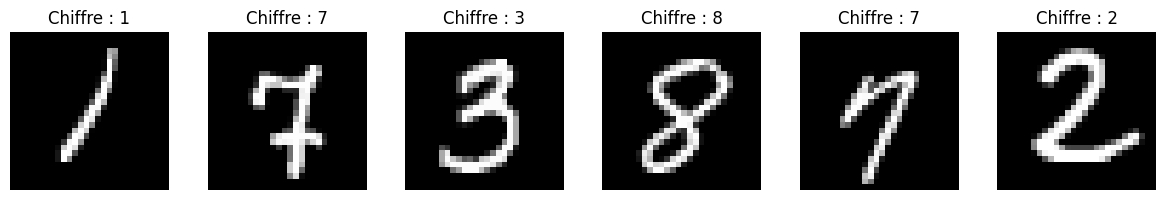

In [4]:
# Récupérer un batch depuis le train_loader
images, labels = next(iter(train_loader))      # images: [batch, 1, 28, 28]

# Dé-normalisation (inverse de Normalize((0.5,), (0.5,)))
images = images * 0.5 + 0.5                    # remet les pixels dans [0, 1]

# Garder seulement 6 exemples
images6 = images[:6]
labels6 = labels[:6]

fig, axes = plt.subplots(1, 6, figsize=(12, 2))

for i in range(6):
    img = images6[i].squeeze(0)               # [1, 28, 28] -> [28, 28]
    axes[i].imshow(img.numpy(), cmap="gray")
    axes[i].set_title('Chiffre : ' + str(labels6[i].item()))
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## **Question 1 : Définition de l'encodeur et du décodeur**

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.latent_size = latent_size
        self.layer = nn.Linear(in_features=p*p, out_features=latent_size)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer(x)          # projection vers l’espace latent
        x = self.activation(x)     # activation : Sigmoïde
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.latent_size = latent_size
        self.layer = nn.Linear(in_features=latent_size, out_features=p*p)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        x = self.layer(x)          # repasse du latent à l’image aplatie
        x = self.activation(x)     # activation : Tangeante hyperbolique
        return x

## **Question 2 : Implémentation de la divergence de Kullback-Leibler**

Le terme **KL** est une **pénalité de sparcité**. Elle force le réseau à produire des activations dont la moyenne est proche de ρ, c’est-à-dire rarement activées. <br>
Ainsi, même si la reconstruction pousse les neurones à s’activer pour bien reconstruire l’image, le terme de sparsité les pousse à ne s’activer que quand vraiment nécessaire.

Le paramètre **rho** représente la valeur cible de l’activation moyenne des neurones du code latent. <br>
Plus **rho** est petit, plus l'auto-encodeur est parcimonieux, plus les activations sont rares.

## Définition de l'auto-encodeur variationnel

In [ ]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, p*p)
        h = self.E(x)
        self.data_rho = h.mean(0) # calculates rho from encoder activations
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, p*p)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

## **Question 3 : Variation de la taille de l'espace latent**

In [18]:
# Définition du modèle à tester 
latent_dims = [16, 128, 512]

models = {}
train_logs = {}
test_logs = {}
rho = 0.05

for ld in latent_dims:
    models[str(ld)] = Net(ld).to(device)
    train_logs[str(ld)] = []
    test_logs[str(ld)] = []

In [ ]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        for model in models.values():
            model.to(device)
            model.optim.zero_grad()
            inputs = data.clone().detach()

            output = model(inputs)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()

    line = f"Époque {epoch} — "
    losses = " ".join(
        [f"{k}: {m._loss.item():.6f}" for k, m in models.items()]
    )

    if log is not None:
        for k in models:
            log[k].append((models[k]._loss, models[k]._rho_loss))

    print(line + losses)


In [20]:
avg_lambda = lambda l: "perte: {:.4f}".format(l)
rho_lambda = lambda p: "régularisation: {:.4f}".format(p)
line = lambda i, l, p: "{}: ".format(i) + avg_lambda(l) + "\t" + rho_lambda(p)
  
# Fonction de test
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}

    with torch.no_grad():
        for data, _ in loader:
            # envoyer les données sur le device
            data = data.to(device)

            inputs = data.clone().detach()   

            # sortie de chaque modèle
            output = {k: m(inputs) for k, m in models.items()}

            for k, m in models.items():
                # perte de reconstruction sur GPU
                test_loss[k] += m.loss(output[k], data, reduction="sum").item()
                # pénalité de sparsité
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * p**2)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = "\n".join([line(k, test_loss[k], rho_loss[k]) for k in models]) + "\n"
    report = "Jeu de test :\n" + lines        
    print(report)


In [21]:
Nepochs = 10

for ld in latent_dims:
    name = str(ld)
    print("\n" + "="*60)
    print(f"=== Entraînement du modèle latent_dim = {ld} ===")
    print("="*60)

    model = models[name]

    # Boucle d'entraînement
    for epoch in range(1, Nepochs+1):
        model.train()
        train(epoch, {name: model}, train_logs)

        model.eval()
        test({name: model}, valid_loader, test_logs)

    # Sauvegarde du modèle
    save_path = f"Models/model_latent_{ld}.pt"
    torch.save(model.state_dict(), save_path)
    print(f"Modèle latent_dim={ld} sauvegardé dans {save_path}\n")



=== Entraînement du modèle latent_dim = 16 ===
Époque 1 — 16: 0.290488
Jeu de test :
16: perte: 0.2978	régularisation: 0.0985

Époque 2 — 16: 0.251056
Jeu de test :
16: perte: 0.2628	régularisation: 0.0782

Époque 3 — 16: 0.238261
Jeu de test :
16: perte: 0.2444	régularisation: 0.0527

Époque 4 — 16: 0.236284
Jeu de test :
16: perte: 0.2268	régularisation: 0.0410

Époque 5 — 16: 0.209725
Jeu de test :
16: perte: 0.2087	régularisation: 0.0325

Époque 6 — 16: 0.197658
Jeu de test :
16: perte: 0.1932	régularisation: 0.0300

Époque 7 — 16: 0.180421
Jeu de test :
16: perte: 0.1807	régularisation: 0.0150

Époque 8 — 16: 0.179615
Jeu de test :
16: perte: 0.1702	régularisation: 0.0132

Époque 9 — 16: 0.160603
Jeu de test :
16: perte: 0.1615	régularisation: 0.0122

Époque 10 — 16: 0.153400
Jeu de test :
16: perte: 0.1542	régularisation: 0.0118

Modèle latent_dim=16 sauvegardé dans Models/model_latent_16_regular_loss.pt


=== Entraînement du modèle latent_dim = 128 ===
Époque 1 — 128: 0.188154


Tracée de la perte sur les données de test au cours des époques (utile pour détecter un surajustement):

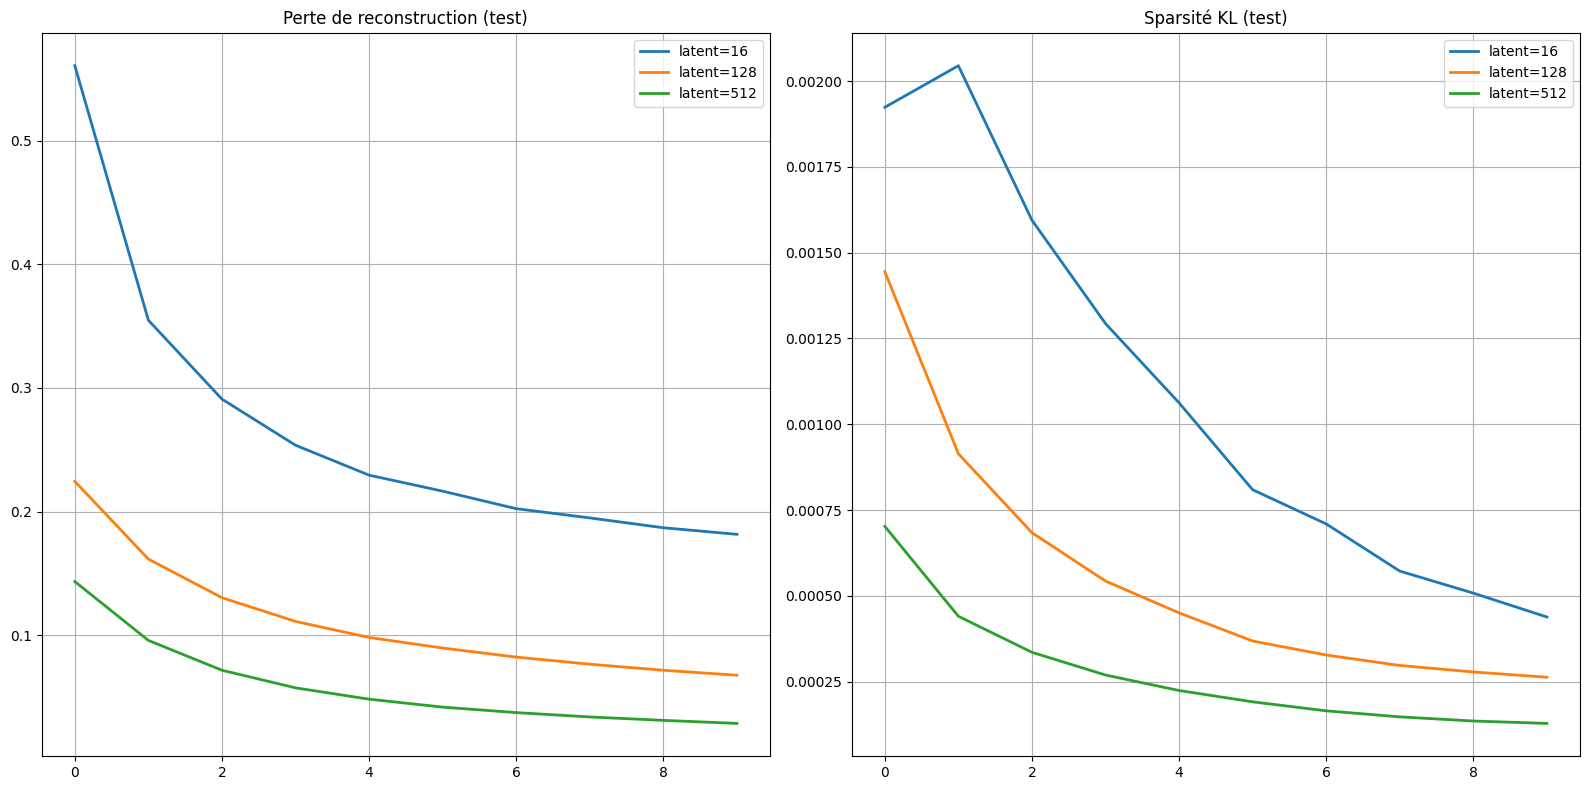

In [13]:
import matplotlib.pyplot as plt
import numpy as np

latent_dims = [16, 128, 512]

# figure avec 2 plots empilés
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

colors = ["tab:blue", "tab:orange", "tab:green"]  # une couleur par latent_dim

for color, ld in zip(colors, latent_dims):

    # --- 2. Charger le modèle depuis le fichier ---
    model = Net(ld).to(device)
    model.load_state_dict(torch.load(f"Models/model_latent_{ld}.pt", map_location=device))
    model.eval()
    # ------------------------------------------------

    name = str(ld)
    test_arr = np.array(test_logs[name])

    # Reconstruction
    ax[0].plot(test_arr[:, 0], label=f"latent={ld}", color=color, linewidth=2)

    # Sparsité KL
    ax[1].plot(test_arr[:, 1], label=f"latent={ld}", color=color, linewidth=2)

ax[0].set_title("Perte de reconstruction (test)")
ax[1].set_title("Sparsité KL (test)")

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()


Test du modèle sur différents types d'entrée :

1. Reconstruction d'un jeu d'images de l'ensemble de test ;
2. Décodage de vecteurs z appartenant à la base canonique (donc maximalement parcimonieux) ;
3. On compte le nombre d'unités de z dont l'activation est > 1/2. Ensuite, on met à zéro les activations inférieurs à 1/2 et on trace la reconstruction.

In [28]:
# 1. Choisir la dimension latente à tester
lat_dim = 512  # changer entre 16, 128, 512

# 2. Charger le modèle depuis le fichier
model = Net(lat_dim).to(device)
model.load_state_dict(torch.load(f"Models/model_latent_{lat_dim}.pt", map_location=device))
model.eval()

print(f"✔ Modèle latent_dim={lat_dim} chargé !")

# Récupération d’un batch
data, _ = next(iter(test_loader))

# Récupération automatique du device du modèle
model = models[str(lat_dim)]
device = next(model.parameters()).device

# Envoi des données sur le bon device
data = data.to(device)

# ------------------------------
# (1) Reconstruction directe
# ------------------------------
output = model(data)

to_plot = (
    output.view(-1, 1, p, p)
          .clamp(0, 1)
          .detach()
          .cpu()
          .numpy()
)

# ------------------------------
# (2) Décodage des vecteurs One-Hot
# ------------------------------
eye_latent = torch.eye(lat_dim).to(device)

decoded = model.decode(eye_latent)

dec_to_plot = (
    ((decoded.view(-1, 1, p, p) + 1) * 0.5)
        .clamp(0, 1)
        .detach()
        .cpu()
        .numpy()
)

dec_to_plot = dec_to_plot[:256]

# ------------------------------
# (3) Encodage + forçage binaire + décodage
# ------------------------------
with torch.no_grad():

    encoded = model.E(data.view(-1, p*p))   # déjà sur device

    print("Nombre d'unités > 0.5 par échantillon :\n",
          (encoded > 0.5).sum(1))

    encoded = encoded.clone()               # pour éviter modification in-place éventuelle
    encoded[encoded < 0.5] = 0.

    decoded_f = model.decode(encoded)

    f_to_plot = (
        ((decoded_f.view(-1, 1, p, p) + 1) * 0.5)
            .clamp(0, 1)
            .detach()
            .cpu()
            .numpy()
    )


✔ Modèle latent_dim=512 chargé !
Nombre d'unités > 0.5 par échantillon :
 tensor([259, 238, 278, 251, 281, 290, 266, 245, 255, 263, 300, 264, 270, 267,
        289, 240, 272, 245, 212, 273, 263, 255, 262, 261, 256, 242, 254, 266,
        273, 280, 266, 266, 259, 238, 271, 244, 249, 281, 271, 284, 297, 271,
        262, 256, 261, 281, 251, 254, 262, 272], device='cuda:0')


Jeu d'images de test et leurs reconstructions :

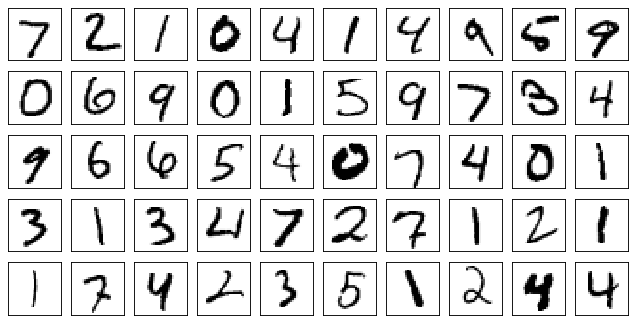

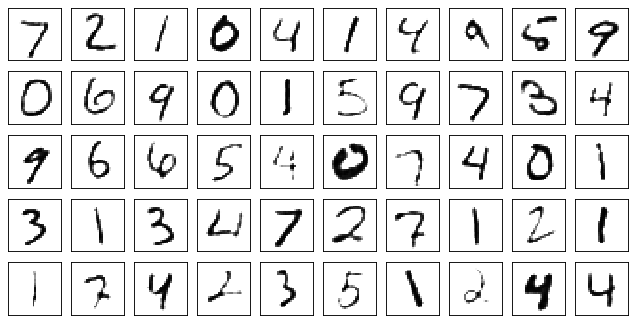

In [29]:
plot_mnist(data.detach().cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))   

Reconstruction des mêmes images, cette-fois ci après avoir mis à zéro les composantes des respectifs codes dont la valeur < 1/2.

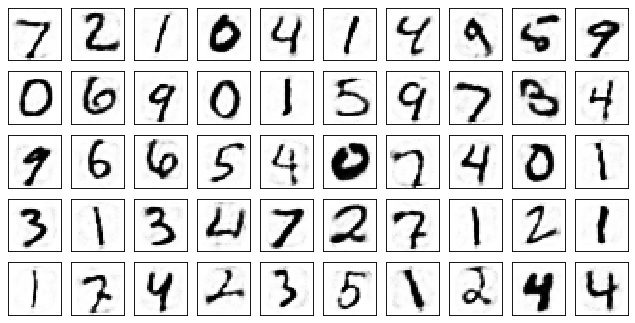

In [30]:
plot_mnist(f_to_plot, (5, 10))

Résultat du décodeur appliqué à des vecteurs de la base canonique (donc maximalement parcimonieux, avec une seule composante non nulle).

In [ ]:
plot_mnist(dec_to_plot, (16, 16))

### Effet de la variation de la taille de l'espace latent 


| latent size | Qualité reconstruction | Parcimonie | Représentativité (1 unité)                |
| ----------- | ---------------------- | ---------- | ----------------------------------------- |
| **16**      | Faible                 | Très bonne | Très grossière, peu utile                 |
| **128**     | Bonne                  | Bonne      | Interprétable, caractéristiques visuelles |
| **512**     | Très bonne             | Mauvaise   | Peu interprétable, micro-détails          |


## **Question 4 : Effet de rho_loss**


En remplaçant la ligne ***rho_loss = model.rho_loss(rho)*** par une simple perte de reconstruction ***loss = model.loss(output, data)***, on observe que la qualité des reconstructions s’améliore, mais que les codes deviennent beaucoup moins parcimonieux et nettement moins interprétables